In [67]:
!pip install country_converter
!pip install dython

#Data Analysis 
import pandas as pd
from pandas import Series
import numpy as np
import country_converter as coco

#Correlation Analysis
from dython.nominal import associations

#Data Vis
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

#Data Vis setting
%matplotlib inline
# sns.set_theme(style="dark")
# mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.Data Manipulation &  Data Cleaning

I will read the dataset and do basic Data Manipulation and Cleaning at the beginning, if I find further problems while analyzing data, I will do further Data Manipulation and Cleaning.

In [68]:
df = pd.read_csv("titles.csv")
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [69]:
df.drop(columns={"description","imdb_id","id"},inplace=True)

Remove unnecessary columns from the dataset.

I will handle with the symbol like: [ , ] , ' from genres and production_countries columns to keep data consistency.

In [70]:
repalce_list = ["[","'","]"]
for i in repalce_list:
    for x in ["genres","production_countries"]:
        df[x] = df[x].str.replace(i,'',regex=True)

Text(0.5, 1.0, 'Missing Values Matrix')

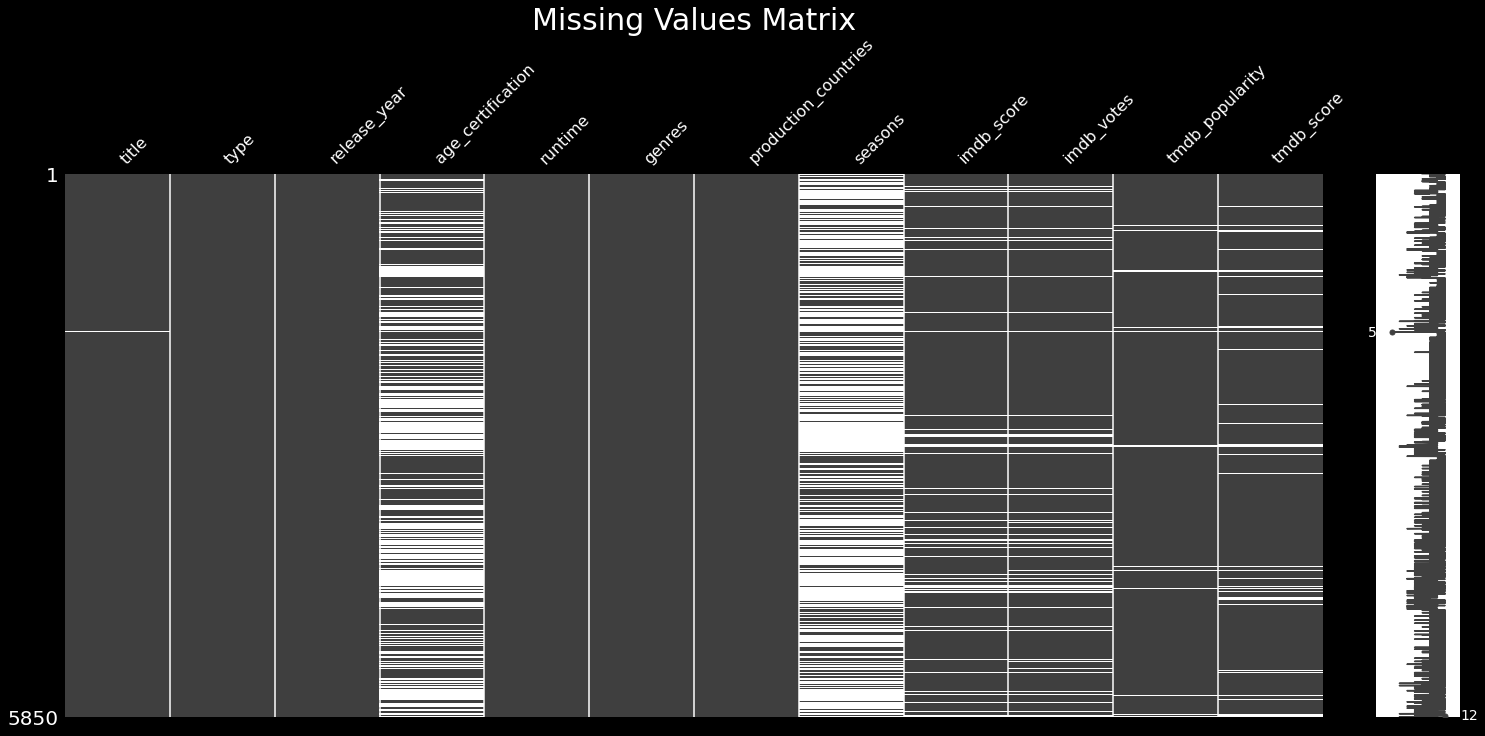

In [71]:
msno.matrix(df)
plt.title("Missing Values Matrix",fontsize=30)

We can see that most of our missing values are from age_certification and seasons columns.

In [72]:
df = df.drop(df[df["title"].isnull()].index)

The NaN value in title columns couldn't be removed using dropna, so I decided to drop that rows directly.

In [73]:
print(df["age_certification"].unique())
df["age_certification"].fillna("Not Rated",inplace=True)

['TV-MA' 'R' 'PG' nan 'TV-14' 'PG-13' 'TV-PG' 'TV-Y' 'TV-G' 'TV-Y7' 'G'
 'NC-17']


I checked the unique catagories in age_certification column and matched them with Netfilx age rating list, I found that the dataset include all of the age rating, and the missing values are those movies or shows that haven't been rated on the website that the data came from.

In [74]:
df[df["seasons"].isnull()]["type"].value_counts()

MOVIE    3743
Name: type, dtype: int64

In [75]:
df["type"].value_counts()

MOVIE    3743
SHOW     2106
Name: type, dtype: int64

I found that all of the missing values in seasons columns are actually movies, it is reasonable that movies don't have any season. Instead of keep them as NaN or drop all of them, I decided to fill them with 0.

In [76]:
df["seasons"].fillna(0,inplace=True)

In [77]:
for i in ["imdb_score","imdb_votes","tmdb_popularity","tmdb_score"]:
    df[i] = df[i].fillna(np.mean(df[i]))

Filling the NaN values from above columns using their own average values.

In [78]:
df.isnull().sum()

title                   0
type                    0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64

There is not missing value in the dataset now.

# 2.Univariate  Analysis

There are two types of columns in the dataset, 
1. Categorical columns
2. Numerical columns.

In this section, we will explore each column and get valuable insights from them using data visualization. I will use plotly, a powerful and high-efficient package for data visualization.

## 2.1 Categorical columns

###2.1.1 Type

Task:
1. What is the distribution of type?

In [79]:
type_count = df["type"].value_counts()

type_fig = px.pie(values=type_count.values,names=type_count.index,color_discrete_sequence=px.colors.qualitative.T10,template="plotly_dark",title="Type distribution")
type_fig.update_traces(textinfo='label+percent+value', textfont_size=12)
type_fig.show()

In this dataset, 36% data is Show and 64% data is Movie

### 2.1.2 Age certification

Task:
1. What are the top 10 frequent age certification?

In [80]:
age_count = df["age_certification"].value_counts()[:10]
age_fig = px.bar(y=age_count.values,x=age_count.index,text=age_count.values,title="Top 10 Age certification count",color=age_count.index,color_discrete_sequence=px.colors.qualitative.T10,template="plotly_dark")
age_fig.update_layout(xaxis_title="Age certification",yaxis_title="Count")
age_fig.show()

The most frequent age certification is Not Rated, which has 2618 results, the second one is TV-MA, which is the TV Parental Guidelines signifies content for mature audiences, has 883 results. 

### 2.1.3 Genres analysis

Task:
1. What are the top 10 frequent genre?

In [81]:
df["genres"]

0                           documentation
1                            drama, crime
2       drama, action, thriller, european
3                 fantasy, action, comedy
4                             war, action
                      ...                
5845                       romance, drama
5846                                drama
5847                               comedy
5848                                     
5849            family, animation, comedy
Name: genres, Length: 5849, dtype: object

We can see there are some shows or movies have more than one genre, counting each genre combination as a new catagory might not be a good decision, so I would like to split them into single genres and count them.

In [82]:
genres = []

for i in df['genres']:
    for s in i.split(","):
        s = s.lower().strip()
        genres.append(s)

genres = [x for x in genres if x]#remove empty string in the counter
top_10_genres = pd.Series(genres).value_counts()[:10]

In [83]:
genres_fig = px.bar(y=top_10_genres.values,x=top_10_genres.index,text=top_10_genres,title="Top 10 Genres",color=top_10_genres.index,color_discrete_sequence=px.colors.qualitative.T10,template="plotly_dark")
genres_fig.update_layout(xaxis_title="Genre",yaxis_title="Count")
genres_fig.show()

###2.1.4 Production Counties analysis

In [84]:
country_list = []
for i in df["production_countries"]:
    for s in i.split(","):
        s = s.strip()
        country_list.append(s)

pd.Series(country_list).unique()
country_list = [i.replace("Lebanon","LB") for i in country_list]
 # I found that there is a wrong data need to be cleaned, Lebanon, should be LB
 
country_list = [i for i in country_list if i]
country_list = pd.Series(country_list).value_counts()
country_list = country_list.drop(index=["SU","XX"])
country_list.index.unique()

Index(['US', 'IN', 'GB', 'JP', 'FR', 'KR', 'CA', 'ES', 'DE', 'MX',
       ...
       'PY', 'VE', 'CU', 'GL', 'HR', 'BY', 'DZ', 'BF', 'BS', 'FO'],
      dtype='object', length=106)

I used the same counting method for the production_countries columns. When I was processing the data, I found and solved two problems:
1. There is a category called Lebanon, which is inconsistent with the other 2 digits country codes, so I replaced it with LB.
2. There are 2 country codes that can not be found: SU and XX. I dropped their data in case of failure to visualize the world map below.

In [85]:
country_list.index = coco.convert(names=country_list.index, to="ISO3") 

I converted all of the valid two digits counrty codes to ISO3 format.

In [86]:
fig = px.choropleth(locations=country_list.index,
                    color=country_list.values,
                    color_continuous_scale=px.colors.sequential.Teal,
                    template='plotly_dark',
                    title = 'Production Counties Distribution Map')
fig.update_layout(font = dict(size= 17, family="Franklin Gothic"))
fig.show()

As the world map shows above, it obvious to find that the United States has the darkest color, which means, for this dataset,  the United States produces the most of shows and movies.

## 2.2.Numeric Columns Analysis

###2.2.1 Release Year

In [87]:
year_df = [df[df["type"]=="MOVIE"]["release_year"],df[df["type"]=="SHOW"]["release_year"]]
Year_label = ["Type: Movie","Type: Show"]
color = ["yellow","red"]

year_fig = ff.create_distplot(year_df,Year_label,colors=color,show_hist=False)
year_fig.layout.template = "plotly_dark"
year_fig.update_layout(font = dict(size = 13,family="Franklin Gothic"))
year_fig.update_layout(title="Runtime Distribution",font=dict(size = 13,family="Franklin Gothic"))
year_fig.update_layout(xaxis_title="Runtime",yaxis_title="Density")
year_fig.show()

Most of the shows in the dataset relased around the second half of 2019, and most of the movies released around the first half of 2019.

###2.2.2 Seasons

In [88]:
seasons_fig = px.box(y=df[df['seasons']!=0]["seasons"],template= 'plotly_dark', title = 'Season Analysis(Boxplot)')
seasons_fig.update_layout(font = dict(size=17,family="Franklin Gothic"))


In [89]:
df[df['seasons']==42]

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
91,Survivor,SHOW,2000,TV-PG,48,reality,US,42.0,7.4,24687.0,54.19,7.4


I removed the movies data in this case because movies don't have an actual season, even though I assigned 0 for them, so the seasons column analysis will only include shows data. 

The boxplot shows that most of shows only have 1 season, but there is one show have 42 seasons, which is a show called  Survivor.

###2.2.3 Runtime

In [90]:
runtime_df = [df[df["type"]=="MOVIE"]["runtime"],df[df["type"]=="SHOW"]["runtime"]]
runtime_label = ["Type: Movie","Type: Show"]
color = ["yellow","red"]

runtime_fig = ff.create_distplot(runtime_df,runtime_label,colors=color,show_hist=False)
runtime_fig.layout.template = "plotly_dark"
runtime_fig.update_layout(font = dict(size = 13,family="Franklin Gothic"))
runtime_fig.update_layout(title="Runtime Distribution",font=dict(size = 13,family="Franklin Gothic"))
runtime_fig.update_layout(xaxis_title="Runtime",yaxis_title="Density")
runtime_fig.show()

For movies, the most common runtime is around 96 mins. For shows, the most common runtime is around 45 mins.

# 3.Age Certification Analysis

From this section, I will use different combinations of features to do the analysis and come up with more in-depth insights

Task:

1. What is the average runtime of each type by age certification?


In [91]:
mean_movie_runtime = df.groupby(["type","age_certification"])["runtime"].agg(np.mean).round(0).sort_values(ascending=False)

In [92]:
runtime_age_fig = go.Figure(data=
[go.Bar(name="Movie",x=mean_movie_runtime["MOVIE"].index,y=mean_movie_runtime["MOVIE"].values,text=mean_movie_runtime["MOVIE"].values),
go.Bar(name="Show",x=mean_movie_runtime["SHOW"].index,y=mean_movie_runtime["SHOW"].values,text=mean_movie_runtime["SHOW"].values)])
runtime_age_fig.update_layout(title="Average runtime by type and age certification",xaxis_tickangle=45,xaxis_title="Age certification",yaxis_title="Average Runtime")
runtime_age_fig.layout.template = "plotly_dark"
runtime_age_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"))
runtime_age_fig.show()

* For movies, the age certification of PG-13 has the highest average runtime of 107 mins, the age certification of G has the lowest average runtime of 89 mins.
* For shows, the age certification of TV-MA has the highest average runtime of 43 mins, the age certification of TV-Y has the lowest average runtime of 17 mins.

# 4.Genre Analysis

Task:
1. What is the most and least frequency genres of each type?


In [93]:
df_stack = df.copy()
s = df_stack['genres'].str.split(",").apply(Series, 1).stack()
s= s.apply(lambda x: x.lower().strip())
s = [x for x in s if x]
s= pd.Series(s)
s.name = 'genres'

del df_stack['genres']
df_stack = df_stack.join(s)

Doing analysis across different featrures also require the same length features, so I decided to split and stack the splited data back to the data frame as a new row in order to keep the same length of different features.

For example, there is a movie has two genres, I will split and stack them back to the dataframe as two rows, one row has the first genre, another will have the second, others values are totally the same.

In [94]:
type_genres_count = df_stack.groupby("type")["genres"].value_counts()

In [95]:
type_genres_fig = go.Figure(data=
[go.Bar(name="Movie",x=type_genres_count["MOVIE"].index,y=type_genres_count["MOVIE"].values,text=type_genres_count["MOVIE"].values),
go.Bar(name="Show",x=type_genres_count["SHOW"].index,y=type_genres_count["SHOW"].values,text=type_genres_count["SHOW"].values)])
type_genres_fig.update_layout(title="Frequency of genres by type",xaxis_tickangle=45,xaxis_title="Genres",yaxis_title="Frequency")
type_genres_fig.layout.template = "plotly_dark"
type_genres_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"),barmode="stack")
type_genres_fig.show()

* The most frequency of genres for both movie and show is drama, the least frequency one is western.

# 5.IMDB Score Correlation Analysis

Task:

1. Which 3 features will have the most impact on the IMDB Score?

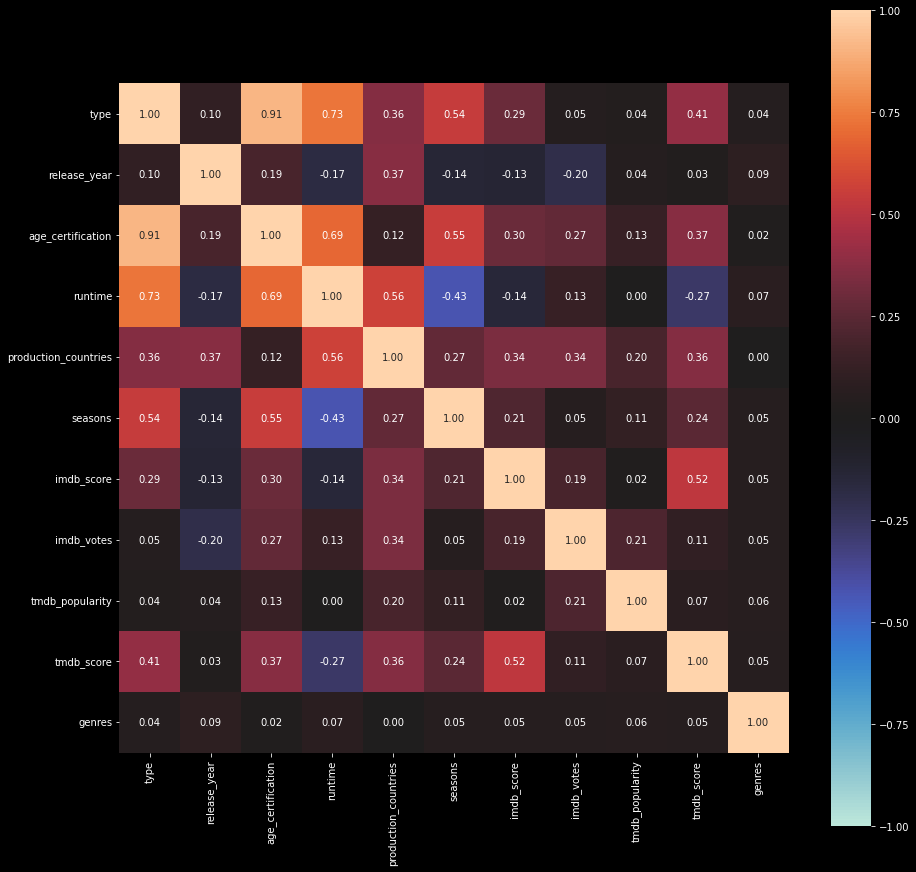

{'corr':                           type  release_year  age_certification   runtime  \
 type                  1.000000      0.104941           0.909659  0.729498   
 release_year          0.104941      1.000000           0.194651 -0.173653   
 age_certification     0.909659      0.194651           1.000000  0.694996   
 runtime               0.729498     -0.173653           0.694996  1.000000   
 production_countries  0.361955      0.368278           0.121405  0.564743   
 seasons               0.541190     -0.140585           0.554392 -0.426640   
 imdb_score            0.289337     -0.125148           0.295160 -0.140811   
 imdb_votes            0.046025     -0.201885           0.267661  0.132617   
 tmdb_popularity       0.037597      0.043085           0.127300  0.002528   
 tmdb_score            0.405309      0.031140           0.370499 -0.269943   
 genres                0.040746      0.091627           0.020612  0.071556   
 
                       production_countries   seasons 

In [96]:
associations(df_stack.drop("title",axis=1),nominal_columns="auto",figsize=(15,15))

I removed the title column to avoid bias because a title is just like an id of a product, which can not bring too much valuable information to my analysis.

The 3 features that will have the most impact on the IMDB Score are:
1. tmdb_score
2. production_countries
3. age_certification

Overall, even the highest correlation score feature, tmdb_score only has a 0.53 correlation score, which means none of the current features can have a significant impact on the imdb_score, it needs more advanced feature engineering or an increase in data size.

# 6. Ends
Thanks for watching my data science project!